<div class='alert alert-info'>
    <h1 align="center">How K-means Culstering Works</h1>
    <h3 align="center">Mo Rahdar</h3>
</div>

# Introduction

K-means clustering is a popular unsupervised machine learning algorithm used for partitioning a dataset into a predetermined number of clusters. The goal of k-means is to group similar data points together and discover underlying patterns in the data.

Here's how the algorithm works:

1. **Initialization**: Begin by selecting the number of clusters, `k`, that you want to identify in the data. Also, randomly initialize k points in the feature space. These points represent the initial cluster centroids.

2. **Assignment**: Assign each data point to the nearest centroid based on a distance metric, commonly Euclidean distance. Each data point belongs to the cluster with the nearest mean (centroid), so each centroid serves as the prototype of the cluster.

3. **Update**: Once all data points are assigned to clusters, compute the new centroids for each cluster by taking the mean of all data points assigned to that cluster. These new centroids represent the updated cluster centers.

4. **Repeat**: Repeat steps 2 and 3 until convergence is reached, i.e., until the centroids no longer change significantly or a predefined number of iterations is reached.

5. **Convergence**: The algorithm is considered to have converged when the assignments of the data points to clusters no longer change or change very minimally between iterations.

6. **Finalization**: Once convergence is achieved, the algorithm outputs the final cluster centroids, along with the assignment of each data point to a particular cluster.

7. **Evaluation**: While k-means does not inherently provide a measure of cluster quality, external validation techniques such as silhouette score or internal validation techniques such as the elbow method can be used to evaluate the quality of the clusters.

It's worth noting that k-means is sensitive to the initial selection of centroids, which may lead to different solutions on different runs. To mitigate this issue, it's common to run the algorithm multiple times with different initializations and choose the solution with the lowest overall within-cluster variation.

K-means is widely used due to its simplicity, efficiency, and effectiveness in many applications such as image segmentation, document clustering, and customer segmentation. However, it also has limitations, such as the need to specify the number of clusters beforehand and its sensitivity to outliers.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs

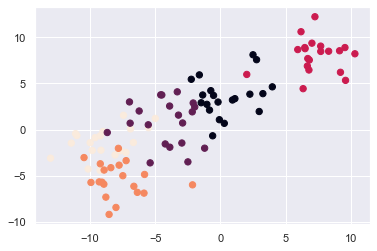

In [2]:
# generate synthetic data
X, y = make_blobs(n_samples=100, centers=5,
                  cluster_std=2, random_state=3)

# plot the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40);

As you see, all datapoints are in gray color, indicating that k-means is an unsupervised learning algorithm, and it doesn't use any labels like `y`. However, we want to partition data points into `k` clusters.

# Define Functions

## Select initial centroids

This function, `initiate_centroids`, is used to randomly select `k` centroids from the given dataset as the initial centroids for the k-means clustering algorithm. It is commonly used as an initial step in the k-means clustering algorithm before iterating through the assignment and update steps.

In [3]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    Inputs:
        k: Number of centroids
        dset: Dataset
    Outputs:
        centroids: An array of initial centroids, each row contains the coordinates of a centroid
    '''
    
    # generate random coordinates for centroids within the range of the dataset
    c1 = np.random.uniform(np.min(X[:,0]), np.max(X[:,0]),k)
    c2 = np.random.uniform(np.min(X[:,1]), np.max(X[:,1]),k)
    
    # combine the random coordinates into a single array representing the centroids
    centroids = np.c_[c1, c2]
    
    return centroids

## Assign data points to the nearest centroid

This function, `centroid_assign`, is responsible for assigning each data point in the dataset to the nearest centroid from a given set of centroids. It is a crucial step in the k-means algorithm and is used in the subsequent step to update the centroids.

In [4]:
def centroid_assign(dset, centroids):
    
    '''
    Given `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    
    Inputs:
        dset: Training data
        centroids: An array of centroids, each row contains the coordinates of a centroid
    Ouputs:
        assign: A list containing the index of the nearest centroid for each data point
                The index corresponds to the position of the centroid in the centroids array
        assign_errors: A list containing the error (Euclidean distance) between each data point
                       in the dataset and its nearest centroid
    '''
    
    k = centroids.shape[0] # number of clusters
    n = dset.shape[0]      # number of points
    assign = []            # list to store assigned centroid indices
    assign_errors = []     # list to store errors (distances) between points and centroids

    for i in range(n): # iterates through each data point in the dataset
        
        all_errors = np.array([])
        for j in range(k):
            err = math.dist(centroids[j, :], dset[i,:]) # calculate Euclidean distance
            all_errors = np.append(all_errors, err)
            
        # get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)
        
        # add values to corresponding lists
        assign.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assign, assign_errors

## Visualize the results of k-means clustering

This function, `plotKmeans`, appears to be a plotting function that visualizes the results of k-means clustering by plotting the dataset points colored by their assigned centroid, and it also marks the centroids on the plot.

In [5]:
def plotKmeans(dset, centroids):
    '''
    The function creates a scatter plot, where each data point is
    colored according to its assigned centroid. Then, it plots the centroids
    as star markers.
    
    Inputs:
        dset: Training data
        centroids: An array of centroids, each row contains the coordinates of a centroid
    '''
    
    # assign data points to centroids
    assign, assign_errors = centroid_assign(dset, centroids)

    # plot data points with colors representing their assigned centroid
    plt.scatter(dset[:, 0], dset[:, 1], c=assign, s=40, cmap='rainbow')

    # plot centroids as star markers
    plt.scatter(centroids[:, 0], centroids[:, 1], edgecolor='k',
                c='yellow', marker='*', s=250)        

## Implement the k-means clustering algorithm

The following function performs k-means clustering iteratively, plotting the clustering results at each iteration along with the total error. The process stops when convergence is reached.

In [6]:
def kmean_model(X, k, plot=True):
    '''
    This function implements the k-means clustering algorithm.
    
    Inputs:
        X: The input dataset
        k: The number of clusters
        plot: Plot the dataset if it is True
    Outputs:
        assign: The cluster assignments for each data point (prediction)
        err: The total error at convergence
        centroids: The final centroids
    '''
    
    # initialize an empty list to store the total error for each iteration
    err = []
    j = 0
    goahead = True

    # iterate until convergence
    while(goahead):

        # if it's the first iteration (j == 0), it initializes centroids manually
        if j == 0:
            # retry initialization until all clusters have at least one
            # data point assigned to them. we cannot start with empty clusters.
            not_done = True
            while not_done:
                
                # initialize centroids
                centroids = initiate_centroids(k, X)
                
                # assign data points to centroids
                assign, j_err = centroid_assign(X, centroids)
                
                if len(np.unique(assign)) == k:
                    not_done = False   # initialization is successful
            
        # after the first iteration, it updates the centroids based on the
        # mean of points assigned to each centroid
        else:
            # mean x-coordinate for each cluster
            m1 = [X[assign==i, 0].mean() for i in np.arange(k)]

            # mean y-coordinate for each cluster
            m2 = [X[assign==i, 1].mean() for i in np.arange(k)]

            # combine the lists m1 and m2 column-wise
            centroids = np.c_[m1, m2]

            # assign data points to centroids
            assign, j_err = centroid_assign(X, centroids)

        # append the total error in this iteration to the `err` list
        err.append(np.sum(j_err))

        if plot==True:
            # plot the current clustering result
            ax = plt.subplot(5,3,j+1)
            plotKmeans(X, centroids)
            
            plt.title('Iteration %d\nTotal error: %.2f' %(j, np.sum(j_err)), fontsize=14)
            ax.set_xticklabels([])
            ax.set_yticklabels([])

        # check for convergence
        if j > 0:
            # compare the difference in errors between consecutive iterations
            if err[j-1] - err[j] <= 1E-2:
                goahead = False # indicate convergence

        j += 1 # increment the iteration counter
        
    return assign, err[-1], centroids

# Cluster the data points when k=2

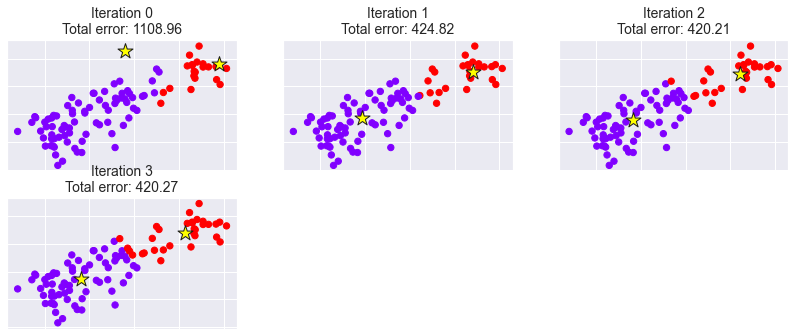

In [7]:
# initialize a figure with a specific size for plotting
plt.figure(figsize=(14,14))

# sets the number of clusters
k = 2

y_pred, error, centroids = kmean_model(X, k)

# Cluster the data points when k=3

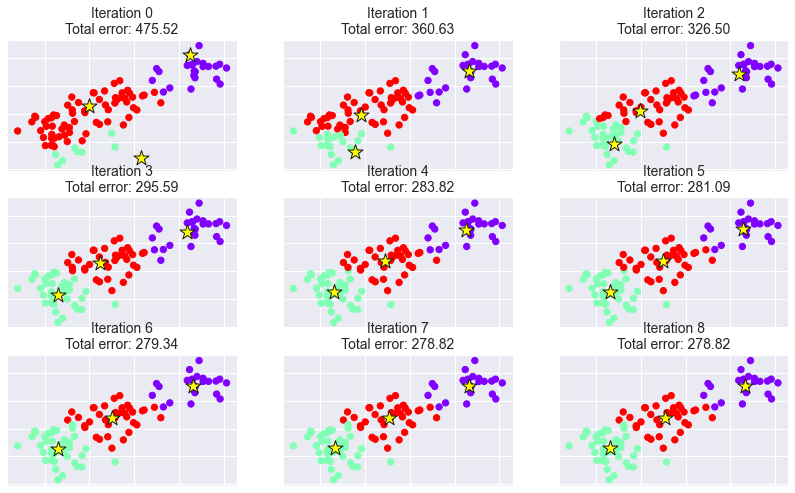

In [8]:
# initialize a figure with a specific size for plotting
plt.figure(figsize=(14,14))

# sets the number of clusters
k = 3

y_pred, error, centroids = kmean_model(X, k)

Determining the appropriate number of clusters, `k`, can indeed be a challenge in unsupervised learning, particularly for algorithms like k-means and often requires a combination of analytical techniques, domain knowledge, and judgment. Here are some reasons why:

1. **No Ground Truth**: In unsupervised learning, there are typically no labels or ground truth to guide the selection of `k`. Unlike in supervised learning where you have labeled data to train and validate your model, in unsupervised learning, you have to rely on intrinsic patterns in the data.

2. **Subjectivity**: The choice of `k` can sometimes be subjective and depend on the context of the problem and the domain knowledge of the data. Different analysts may choose different values of `k` based on their interpretations of the data.

3. **Elbow Method**: One common approach to determining `k` in k-means clustering is the elbow method. This method involves plotting the within-cluster sum of squares (WCSS) as a function of `k` and selecting the value of `k` at the "elbow" of the curve, where the rate of decrease in WCSS slows down. However, identifying the exact elbow point can sometimes be ambiguous, especially if there is no clear "elbow" in the plot.

4. **Silhouette Score**: Another method for selecting `k` is the silhouette score, which measures the quality of the clustering. The silhouette score ranges from -1 to 1, where a higher value indicates better clustering. You can calculate the silhouette score for different values of `k` and choose the `k` with the highest silhouette score. However, this method also has limitations, such as sensitivity to the shape of clusters and the possibility of local optima.

5. **Domain Knowledge**: Incorporating domain knowledge and understanding the context of the problem can help in determining an appropriate value of `k`. For example, in customer segmentation, you might have prior knowledge suggesting a certain number of customer segments based on business goals or market research.

6. **Other Methods**: There are various other methods and heuristics for determining `k`, such as the gap statistic, silhouette analysis, and the Davies–Bouldin index. Each method has its strengths and weaknesses, and the choice of method depends on factors like the dataset size, distribution of data, and computational resources.

# Use Elbow Method to Determine k

In [9]:
max_k = 9

wcss = []
centroids = []
for k in range(1, max_k+1):
    _, error, c = kmean_model(X, k, plot=False)
    wcss.append(error)
    centroids.append(c)

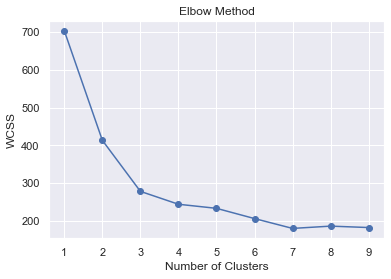

In [10]:
# plot the elbow method curve
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, max_k + 1))
plt.show()

To determine the optimal number of clusters, we need to select the value of `k` at the elbow or the point after which the distortion/inertia starts decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

If we continue to increase the number of clusters, the error (WCSS) will generally decrease. However, this reduction in error is expected because more clusters mean more centroids, and each data point tends to be closer to its assigned centroid, leading to smaller within-cluster distances. This reduction in error does not necessarily mean that the additional clusters provide meaningful or useful information about the underlying structure of the data.

The goal of the elbow method is to find the point where the addition of more clusters does not lead to a significant decrease in the error. Beyond this point, adding more clusters may capture noise or small fluctuations in the data, resulting in overfitting without providing much improvement in the clustering quality.

The "elbow" point represents a trade-off between minimizing the error and avoiding overfitting. It indicates the optimal number of clusters where the clustering solution is considered to be both sufficiently simple and sufficiently representative of the underlying data structure.

## Visualize data points using different k

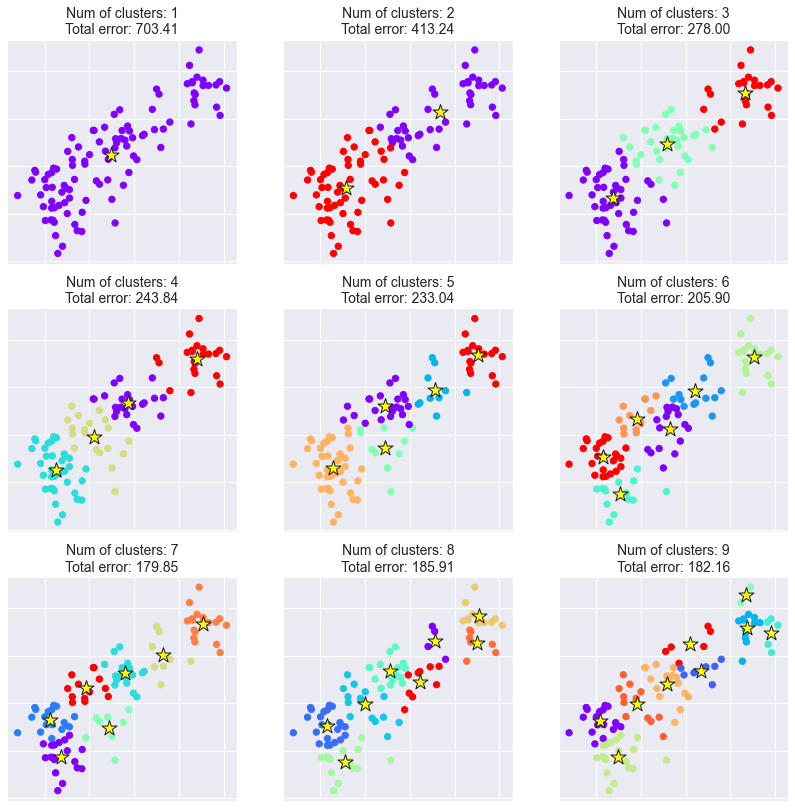

In [11]:
# initialize a figure with a specific size for plotting
plt.figure(figsize=(14,14))

for j in range(9):
    ax = plt.subplot(3,3,j+1)
    plotKmeans(X, centroids[j])
    
    plt.title('Num of clusters: %d\nTotal error: %.2f' %(j+1, wcss[j]), fontsize=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

As you see in the above figure, three clusters can capture useful information about the underlying structure of the data.